In [1]:
data_path = "new_sequences20.dat"

In [2]:
import math
import time
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import matrix_power
from sympy.geometry import Point, Circle
from numpy import pi

In [3]:
tolerance = 1e-6
epsilon = .1

In [4]:
def isOdd(sequence):
    return len(sequence) % 2

In [5]:
def isEven(sequence):
    return not isOdd(sequence)

In [6]:
def genLen(generator):
    return sum(1 for _ in generator)

In [7]:
def cfToMatrix(sequence):
    matrix = np.eye(2, dtype=np.int64)
    for x in sequence:
        matrix = np.matmul(matrix, [[x, 1], [1, 0]])
    return matrix

In [8]:
def npCfReduce(cf): #works on fully periodic continued fractions
    mat = cfToMat(cf)
    return (mat[0,0]-mat[1,1] + math.sqrt(mat[0,0]**2+mat[1,1]**2+2*mat[1,0]*mat[0,1]-2))/(2*mat[1,0])

In [9]:
def cfMatrixTrace(sequence):
    return np.trace(cfToMatrix(sequence))

In [10]:
def asMatrix(sequence):
    return cfToMatrix(sequence + sequence if isOdd(sequence) else sequence)

In [11]:
def matrixTrace(sequence):
    return np.trace(asMatrix(sequence))

In [12]:
def rotl(x, k):
    return x[k:] + x[:k]

In [13]:
def minRot(x, step=1):
    return min(rotl(x, k) for k in range(0, len(x), step))

In [14]:
def minRot2(x):
    return minRot(x, step=2)

In [15]:
def traceToLength(t):
    return 2 * np.arccosh(t / 2)

In [16]:
def lengthToTrace(l):
    return 2 * np.cosh(l / 2)

In [17]:
def actualSequencesGen(data, length):
    min_trace = int(lengthToTrace(length)) + 1
    max_trace = int(lengthToTrace(length + 1)) + 1
    for x in data:
        trace = matrixTrace(x)
        if trace < min_trace or trace >= max_trace:
            x *= int((length + 1) / traceToLength(trace))
        if isOdd(x):
            # Expand condensed form, and then symmetrize by time reversal
            yield x + x
        else:
            # Symmetrize by both R-L flip and time reversal, and add all four
            yield x
            yield rotl(x, 1)

In [18]:
def actualSequences(data, length):
    return list(actualSequencesGen(data, length))

In [19]:
def guysForTraceGen(data, trace):
    length = int(traceToLength(trace))
    sequences = actualSequencesGen(data.get(length), length)
    matched = (x for x in sequences if cfMatrixTrace(x) == trace)
    yield from reduceAndRemoveDuplicatesGen(matched)

In [20]:
def guysForTrace(data, trace):
    return list(guysForTraceGen(data, trace))

In [21]:
def geosInTraceRangeGen(data, tmin, tmax):
    for i in range(tmin, tmax + 1):
        yield from guysForTraceGen(data, i)

In [22]:
def geosInTraceRange(data, tmin, tmax):
    return list(geosInTraceRangeGen(data, tmin, tmax))

In [23]:
def pantsInTraceRange(data, tmin, tmax):
    return getPants(geosInTraceRangeGen(data, tmin, tmax))

def pantsInTraceRange2(data, tmin, tmax):
    return getPants2(geosInTraceRangeGen(data, tmin, tmax))

In [24]:
def pantsInTraceRangeDict(data, tmin, tmax):
    return getPantsDict(geosInTraceRangeGen(data, tmin, tmax))

In [25]:
def reduceAndRemoveDuplicatesGen(sequences):
    for x in {tuple(minRot2(s)) for s in sequences}:
        if minRot2(x[::-1]) != x:
            yield list(x)

In [26]:
def reduceAndRemoveDuplicates(sequences):
    return list(reduceAndRemoveDuplicatesGen(sequences))

In [27]:
def cfListToDicts(cfs):
    forward, reverse = {}, {}
    for cf in cfs:
        for left, right in split(cf):
            if left in forward:
                forward[left].add(right)
            else:
                forward[left] = {right}
            if right in reverse:
                reverse[right].add(left)
            else:
                reverse[right] = {left}
    return forward, reverse

In [28]:
def permutationsOfGen(sequence):
    for n in range(0, len(sequence), 1 if isOdd(sequence) else 2):
        yield rotl(sequence, n)

In [29]:
def permutationsOf(sequence):
    return list(permutationsOfGen(sequence))

In [30]:
def minPermutations(sequence):
    return min(permutationsOfGen(sequence))

In [31]:
def inv(lr_sequence):
    return tuple((np.array(lr_sequence[::-1]) - 1) ** 2)

In [32]:
def splitGen(continued_fraction):
    converted = contFracToLR(continued_fraction)
    n = len(converted)
    for i, j in pairsGen(converted):
        rotated = rotl(converted, i)
        yield (tuple(rotated[1:(j - i) % n]),
               tuple(inv(rotated[(j - i) % n + 1:])))

In [33]:
def split(continued_fraction):
    return list(splitGen(continued_fraction))

In [34]:
def contFracToLRGen(continued_fraction):
    if isOdd(continued_fraction):
        continued_fraction += continued_fraction
    for i in range(len(continued_fraction)):
        for j in range(continued_fraction[i]):
            yield i % 2

In [35]:
def contFracToLR(continued_fraction):
    return list(contFracToLRGen(continued_fraction))

In [36]:
def indicesGen(lr_sequence):
    for i in range(len(lr_sequence)):
        if lr_sequence[i] == 1:
            yield i

In [37]:
def indices(lr_sequence):
    return list(indicesGen(lr_sequence))

In [38]:
def pairsGen(lr_sequence):
    sequence_indices = indices(lr_sequence)
    for i in sequence_indices:
        for j in sequence_indices:
            if i != j:
                yield (i, j)

In [39]:
def pairs(lr_sequence):
    return list(pairsGen(lr_sequence))

In [40]:
def recover(ls):
    output = []
    i = 0
    while i < len(ls):
        counter = 1
        while (i < len(ls) - 1 and ls[i] == ls[i + 1]):
            i += 1
            counter += 1
        i += 1
        output.append(counter)
    if isOdd(output):    #this is the line where we lump things
        output[-1] += output[0]
        output = output[1:]
    return output

def recover2(ls):
    output = []
    i = 0
    while i < len(ls):
        counter = 1
        while (i < len(ls) - 1 and ls[i] == ls[i + 1]):
            i += 1
            counter += 1
        i += 1
        output.append(counter)
    if isOdd(output):  
        output = [0]+output
    return output

In [41]:
def pairToFrac(s1, s2):
    return minPermutations(recover(list(s1) + [1] + list(inv(s2)) + [1]))

def pairToFrac2(s1,s2):
    return recover2(list(s1) + [1] + list(inv(s2)) + [1])

In [42]:
def getPants(cf_list): #output here is set of triples of theta sequences
    forward, reverse = cfListToDicts(cf_list)
    pants = set()
    for s0 in forward:
        for s1 in forward[s0]:
            if s1 in forward and s0 in reverse:
                for s2 in forward[s1].intersection(reverse[s0]):
                    y0 = pairToFrac(s0, s1)
                    y1 = pairToFrac(s1, s2)
                    y2 = pairToFrac(s2, s0)
                    s0i, s1i,s2i = inv(s0), inv(s1), inv(s2)
                    if not (y0 == y1 or y1 == y2 or y0 == y2):
                        if (s1,s2,s0) not in pants and (s2,s0,s1) not in pants and (s2i,s1i,s0i) not in pants and (s1i,s0i,s2i) not in pants and (s0i,s2i,s1i) not in pants:
                            pants.add((s0, s1, s2))
    return pants

def getPants2(cf_list): #output here is list of triples of geos
    forward, reverse = cfListToDicts(cf_list)
    pants = set()
    for s0 in forward:
        for s1 in forward[s0]:
            if s1 in forward and s0 in reverse:
                for s2 in forward[s1].intersection(reverse[s0]):
                    y0 = pairToFrac(s0, s1)
                    y1 = pairToFrac(s1, s2)
                    y2 = pairToFrac(s2, s0)
                    if not (y0 == y1 or y1 == y2 or y0 == y2):
                        pants.add((y0, y1, y2))
    return pants

In [43]:
def getPantsDict(cf_list):
    forward, reverse = cfListToDicts(cf_list)
    pantsDict = {}
    for s0 in forward:
        for s1 in forward[s0]:
            if s1 in forward and s0 in reverse:
                for s2 in forward[s1].intersection(reverse[s0]):
                    y0 = tuple(pairToFrac(s0, s1))
                    y1 = tuple(pairToFrac(s1, s2))
                    y2 = tuple(pairToFrac(s2, s0))
                    s0i, s1i,s2i = inv(s0), inv(s1), inv(s2)
                    if not (y0 == y1 or y1 == y2 or y0 == y2):
                        if y0 in pantsDict and (s1,s2,s0) not in pantsDict[y0] and (s2,s0,s1) not in pantsDict[y0] and (s2i,s1i,s0i) not in pantsDict[y0] and (s1i,s0i,s2i) not in pantsDict[y0] and (s0i,s2i,s1i) not in pantsDict[y0]:
                            pantsDict[y0].add((s0,s1,s2))
                        else:
                            pantsDict[y0] = {(s0,s1,s2)}
                        if y1 in pantsDict and (s1,s2,s0) not in pantsDict[y0] and (s2,s0,s1) not in pantsDict[y0] and (s2i,s1i,s0i) not in pantsDict[y0] and (s1i,s0i,s2i) not in pantsDict[y0] and (s0i,s2i,s1i) not in pantsDict[y0]:
                            pantsDict[y1].add((s0,s1,s2))
                        else:
                            pantsDict[y1] = {(s0,s1,s2)}
                        if y2 in pantsDict and (s1,s2,s0) not in pantsDict[y0] and (s2,s0,s1) not in pantsDict[y0] and (s2i,s1i,s0i) not in pantsDict[y0] and (s1i,s0i,s2i) not in pantsDict[y0] and (s0i,s2i,s1i) not in pantsDict[y0]:
                            pantsDict[y2].add((s0,s1,s2))
                        else:
                            pantsDict[y2] = {(s0,s1,s2)}
    return pantsDict

In [44]:
def pantsInTraceRangeWithCuff(data, tmin, tmax, cutting_sequence):
    pants_with_cuff = []
    for pants in pantsInTraceRange(data, tmin, tmax):
        if cutting_sequence in pants:
            pants_with_cuff.append(pants)
    return pants_with_cuff

In [45]:
def pantsInTraceRangeWithCuffGen(data, tmin, tmax, cutting_sequence):
    for pants in pantsInTraceRange(data, tmin, tmax):
        if cutting_sequence in pants:
            yield pants

In [46]:
def boundaryCountForOrientedCuffs(data, tmin, tmax, cutting_sequence):
    cutting_sequence_reverse = cutting_sequence[::-1]
    positive = pantsInTraceRangeWithCuffGen(data, tmin, tmax, minPermutations(cutting_sequence))
    negative = pantsInTraceRangeWithCuffGen(data, tmin, tmax, minPermutations(cutting_sequence_reverse))
    return genLen(positive) - genLen(negative)

In [47]:
def cfToMat(cf):
    mat = np.identity(2)
    length = 0
    for x in cf:
        mat = np.matmul(mat, [[x, 1], [1, 0]])
        length += 1
    if length % 2:
        mat = np.matmul(mat, mat)
    return np.array(mat).astype(int)

In [48]:
def halfLength(cf):
    return math.acosh(np.trace(cfToMat(cf))/2)

In [49]:
def pantsToGeodesics(pants_list):
    positives = []
    for pants in pants_list:
        geos = [pairToFrac(pants[0], pants[1]), pairToFrac(pants[1], pants[2]), pairToFrac(pants[2], pants[0])]
        for geodesic in geos:
            min_geo = minPermutations(geodesic)
            min_inv_geo = minPermutations(min_geo[::-1])
            if not (min_geo in positives or min_inv_geo in positives):
                positives.append(min_geo)
    return positives

In [50]:
def geosToEyesGen(geodesics):
    for geodesic in geodesics:
        for i in range(0, len(geodesic), 2):
            rotated = rotl(list(geodesic), i)[1:]
            rotated[0] -= 1
            rotated[-1] -= 1
            yield (geodesic, tuple(rotated))

In [51]:
def geosToEyes(geodesics):
    return list(geosToEyesGen(geodesics))

In [52]:
def cuspInv(cusp):
    inv_cusp = list(cusp[::-1])
    if len(inv_cusp) == 1 and inv_cusp[0] <= 0:
        return tuple(inv_cusp)
    else:
        if inv_cusp[0] == 0:
            inv_cusp = inv_cusp[1:]
        else:
            inv_cusp = [0] + inv_cusp
        if inv_cusp[-1] == 0:
            inv_cusp = inv_cusp[:-1]
        else:
            inv_cusp = inv_cusp + [0]
        return tuple(inv_cusp)

In [53]:
def eyesToCusps(eyes):
    cusps = []
    for eye in eyes:
        eye = eye[1]
        inv_eye = cuspInv(eye)
        if not (eye in cusps or inv_eye in cusps):
            cusps.append(eye)
    return cusps

In [54]:
def pantsAndEyesToMatrix(pants_list, eye_list, pos_geos, pos_cusps):
    geo_indices, cusp_indices = {}, {}
    basis_count = len(pos_geos) + len(pos_cusps)
    
    for i in range(basis_count):
        if i < len(pos_geos):
            geo_indices[pos_geos[i]] = i 
        else:
            cusp_indices[pos_cusps[i - len(pos_geos)]] = i

    columns = []
    for pants in pants_list:
        column = np.zeros(basis_count)
        for geo in pants:
            if geo in geo_indices:
                column[geo_indices[geo]] = 1
            else:
                column[geo_indices[minPermutations(geo[::-1])]] = -1
        columns.append(column)
    
    for eye in eye_list:
        column = np.zeros(basis_count)
        if eye[0] in geo_indices:
            column[geo_indices[eye[0]]] = 1
        else:
            column[geo_indices[minPermutations(eye[0][::-1])]] = -1
        if eye[1] in cusp_indices:
            column[cusp_indices[eye[1]]] = 1
        else:
            column[cusp_indices[cuspInv(eye[1])]] = -1
        columns.append(column)
    
    return np.column_stack(columns)

In [55]:
class LineReader:
    """
    Read a static file with smart line access.

    WARNING: This implementation assumes that the file does not change between
    calls of the `clear` function and never checks for valid file handlers.
    """

    def __init__(self, file_handle=None, parser=lambda e: e):
        """Initialize the LineReader."""
        self.file_handle = file_handle
        self.parser = parser
        self.clear()

    def clear(self):
        """Clear line cache and offset table."""
        self.cache = {}
        self.offsets = []

    def get(self, n):
        """
        Get line as fast as possible, using the line cache and offset table.
        """
        line = self.cache.get(n)
        if line is not None or n < 0:
            return line
        offset_index = len(self.offsets) - 1
        if offset_index >= n:
            self.file_handle.seek(self.offsets[n])
            self.cache[n] = self.parser(self.file_handle.readline()[:-1])
            return self.cache[n]
        if not self.offsets:
            self.offsets.append(0)
            offset_index = 0
        self.file_handle.seek(self.offsets[-1])
        for (index, line) in enumerate(self.file_handle, start=offset_index):
            self.offsets.append(self.offsets[-1] + len(line))
            if index == n:
                self.cache[n] = self.parser(line[:-1])
                return self.cache[n]
        return None

In [56]:
def getOrtho(circ1,circ2):
    r1,x1 = circ1 
    r2,x2 = circ2
    if abs(x1-x2)<tolerance:
        return (np.inf, (x1+x2)/2)
    c1 = x1**2-r1**2
    c2 = x2**2-r2**2
    h = (c1-c2)/(2*(x2-x1))
    x3 = -h
    r3 = math.sqrt(h**2+2*x1*h+c1)
    return (r3, x3)

In [57]:
def toInterval(circ): #we implicitly assume that we can never have trivial intervals of (x,x) = emptyset
    r,x = circ
    if r==np.inf:
        return (x,np.inf)
    elif r==np.NINF:
        return (np.NINF,x)
    else:
        return (x-r, x+r)

In [58]:
def getDist(circ1,circ2):
    circ1,circ2 = getInv(circ1), getInv(circ2)
    t1,u1,v1 = circ1
    t2,u2,v2 = circ2
    a = (t1*u2/2+t2*u1/2-v1*v2)
    return math.acosh(abs(a)+tolerance)

In [59]:
def getInv(circ):
    r,x = circ
    if r == np.inf or r == np.NINF:
        return (2*x,0,1)
    return ((x**2-r**2)/r, 1/r, x/r)

In [60]:
def InvToNormal(circ,N):
    t,u,v = circ
    if abs(u)<tolerance:
        return (np.inf,t/2)
    else:
        r = 1/u
        x = r*v
        return (r,x)

In [61]:
def pIsIn(p,interval): # open intervals
    if interval[0] < interval[1]:
        return interval[0] < p and p < interval[1]
    else:
        return interval[0] < p or p < interval[1]

In [62]:
def intIsIn(int1, int2): # returns whether interval 1 contains interval 2 (i.e. True = "1 contains 2")
    if int1[0] < int1[1] and int2[0] < int2[1]:
        return int1[0] <= int2[0] and int1[1] >= int2[1]
    elif int1[0] > int1[1] and int2[0] < int2[1]:
        return int1[0] <= int2[0] or int2[1] <= int1[1]
    elif int1[0] > int1[1] and int2[0] > int2[1]:
        return int1[0] <= int2[0] and int1[1] >= int2[1]
    else:
        return False

In [63]:
def act(M,x):
    return (M[0,0]*x+M[0,1])/(M[1,0]*x+M[1,1])

In [64]:
def radiusCenterPlotter(circArray,s= 5): #draw circle given an array of radii and centers
    fig, ax = plt.subplots()
    fig.set_size_inches(s, s)
    circles = [circ for circ in circArray if circ[0]!=np.inf and circ[0]!=-np.inf]
    lines = [line for line in circArray if line[0]==np.inf or line[0]==-np.inf]
    minimum = min([circ[1]-abs(circ[0]) for circ in circles]+[l[1] for l in lines])
    maximum = max([circ[1]+abs(circ[0]) for circ in circles]+[l[1] for l in lines])
    ranges = maximum-minimum
    maximum+=ranges/20
    minimum-=ranges/20
    maxY = max([abs(circ[0]) for circ in circles])
    maxY+=maxY/20
    ax.set_xlim(float(minimum),float(maximum))
    ax.set_ylim(0, float(maxY))
    
    for circ in circles:
        plotCirc = plt.Circle((circ[1],0), abs(circ[0]), fill = False)
        if circ[0] > 0:
            plt.plot(circ[1], abs(circ[0]), '>')
        else:
            plt.plot(circ[1], abs(circ[0]), '<')
        ax.add_artist(plotCirc)
    for line in lines:
        plt.vlines(line[1], 0, float(maxY))
        if line[0]> 0:
            plt.plot(line[1],float(maxY/2), '^')
        else:
            plt.plot(line[1],float(maxY/2), 'v')
    ax.set_aspect('equal', adjustable='box')

In [65]:
def circlePoints(circ, N = 100):
    r,x = circ
    x_values,y_values = [],[]
    for i in range(N+1):
        curr_x = x+abs(r)*math.cos(math.pi*i/N)
        curr_y = abs(r)*math.sin(math.pi*i/N)
        x_values.append(curr_x)
        y_values.append(curr_y)
    if r < 0:
        return (x_values,y_values)
    else:
        return (x_values[::-1],y_values[::-1])

In [66]:
def h(point):
    xVals, yVals = point[0][0], point[0][1]
    output = [[],[]]
    for i in range(len(xVals)):
        x,y = xVals[i],yVals[i]
        a = x**2+(y+1)**2
        output[0].append((x**2+y**2-1)/a)
        output[1].append(-2*x/a)
    return output

In [67]:
def add_arrow(line, position=None, direction='right', size=15):
    """
    add an arrow to a line.

    line:       Line2D object
    position:   x-position of the arrow. If None, mean of xdata is taken
    direction:  'left' or 'right'
    size:       size of the arrow in fontsize points
    color:      if None, line color is taken.
    """
    xdata = line.get_xdata()
    ydata = line.get_ydata()

    if position is None:
        position = xdata.mean()
    # find closest index
    start_ind = np.argmin(abs(xdata - position))
    if direction == 'right':
        end_ind = start_ind + 1
    else:
        end_ind = start_ind - 1

    line.axes.annotate('',
        xytext=(xdata[start_ind], ydata[start_ind]),
        xy=(xdata[end_ind], ydata[end_ind]),
        arrowprops=dict(arrowstyle='simple'),
        size=size
    )

In [68]:
def radiusCenterPlotter2(circArray,s=5,n=0): #draw circle given an array of radii and centers
    if n==0:
        n = len(circArray)
    dashed_val = 'solid'
    fig, ax = plt.subplots()
    fig.set_size_inches(s, s)
    circles = [circ for circ in circArray if circ[0]!=np.inf and circ[0]!=-np.inf]
    lines = [line for line in circArray if line[0]==np.inf or line[0]==-np.inf]
    ax.set_xlim(-1,1.01)
    ax.set_ylim(-1.001,1.001)
    points = []
    plotCirc = plt.Circle((0,0), 1, fill = False)
    ax.add_artist(plotCirc)
    plotCirc = plt.Circle((1,0), math.log(s)/100, fill = True, color = 'black', clip_on = False)
    ax.add_artist(plotCirc)
    plotCirc = plt.Circle((0,-1), math.log(s)/100, fill = True, color = 'black', clip_on = False)
    ax.add_artist(plotCirc)
    plotCirc = plt.Circle((-1,0), math.log(s)/100, fill = True, color = 'black', clip_on = False)
    ax.add_artist(plotCirc)
    for circ in circles:
        points += [(circlePoints((circ[0], circ[1])),)]
    for i in range(len(circles)):
        circ = circles[i]
        x_values,y_values = h(points[i])
        if i>(n-1):
            dashed_val = 'dashed'
        line = plt.plot(x_values,y_values, 'black', linewidth = .3, linestyle = dashed_val)[0]    
        pos = len(x_values)//2
        angle = 180*math.atan2((y_values[pos+1]-y_values[pos]),(x_values[pos+1]-x_values[pos]))/math.pi
        plt.plot(x_values[pos],y_values[pos], marker = (3, 0, angle+35), markersize=10, linestyle='None')
   
    for line in lines:
        points = [[(line[1],line[1],line[1]),(5,10,15)]]
        points = h(points)
        p = points
        points = (Point(p[0][0],p[1][0]), Point(p[0][1],p[1][1]), Point(p[0][2],p[1][2]))
        circ = Circle(points[0],points[1],points[2])
        r,center = circ.radius, (circ.center[0].evalf(),circ.center[1].evalf())
        plotCirc = plt.Circle((center[0],center[1]), abs(r), fill = False, linestyle = 'dashed')
        ax.add_artist(plotCirc)
        #if line[0]< 0:
        #    add_arrow(plotCirc,position = x_values[len(x_values)//2], direction = 'right')
        #else:
        #    add_arrow(plotCirc,position = x_values[len(x_values)//2], direction = 'left')
    ax.set_aspect('equal', adjustable='box')
    plt.axis('off')
    ax.annotate(r"$\infty$",(1,0),(1+math.log(s)/50,-math.log(s)/55), size = 15*math.log(s))
    #plt.plot((1,0),color = 'black', marker = "o", markersize=10)
    plt.show()

In [69]:
def pantsInPlane(pants): #y0 is on top, y2 on left, y1 in default position (reduced position +1)
    circles = []
    s0,s1,s2 = pants
    y2 = pairToFrac2(s0,s1)
    y0 = pairToFrac2(s1,s2)
    y1 = pairToFrac2(s2,s0)
    B = lambda x : 1/(1-x)
    
    alpha = npCfReduce(y0)
    alpha_conj = -1/(npCfReduce(y0[::-1]))
    x_min = B(alpha_conj+1)
    x_max = B(alpha+1)
    r = (x_max-x_min)/2
    x = (x_min+x_max)/2
    circles.append((r,x))
    
    alpha = npCfReduce(y1)
    alpha_conj = -1/(npCfReduce(y1[::-1]))
    x_min = (alpha_conj+1)
    x_max = (alpha+1)
    r = (x_max-x_min)/2
    x = (x_min+x_max)/2
    circles.append((r,x))
    
    alpha = npCfReduce(y2)
    alpha_conj = -1/(npCfReduce(y2[::-1]))
    x_min = B(B(alpha_conj+1))
    x_max = B(B(alpha+1))
    r = (x_max-x_min)/2
    x = (x_min+x_max)/2
    circles.append((r,x))
    
    return circles

In [70]:
def pantsPutterInv(pants1, pants2, # pants1 contains y, pants2 contains inv(y)
                   y, s = 5, vis = True): # y is given in minimal form, without any 0's 
    s0,s1,s2 = pants1
    pants1Arr = []
    
    pants1Arr.append(pairToFrac(s1,s2))
    pants1Arr.append(pairToFrac(s2,s0))
    pants1Arr.append(pairToFrac(s0,s1))
    #pair to frac here sends extra R's at the front to the end, so it makes sense to compare to y later.
    
    i = -1
    for l in range(3):
        if pants1Arr[l] == y:
            i = l
    
    pants1_new = [pairToFrac2(s1,s2),pairToFrac2(s2,s0),pairToFrac2(s0,s1)]
    pants1_new = pants1_new[i:] + pants1_new[:i]
    pants1  = pants1[i:] + pants1[:i]
    
    #the above puts the cuff that matches to y into the first slot of the array
    #example: if i = 1, then pants1_new = [gamma1,gamma2,gamma0], and pants1 = [s1,s2,s0]
    
    s0,s1,s2 = pants2
    
    pants2Arr = []
    
    pants2Arr.append(pairToFrac(s1,s2))
    pants2Arr.append(pairToFrac(s2,s0))
    pants2Arr.append(pairToFrac(s0,s1))
    
    for l in range(3):
        if minPermutations(pants2Arr[l][::-1]) == y:
            i = l
    
    pants2_new = [pairToFrac2(s1,s2),pairToFrac2(s2,s0),pairToFrac2(s0,s1)]
    pants2_new = pants2_new[i:] + pants2_new[:i]
    pants2 = pants2[i:] + pants2[:i]
    #the above puts the cuff that matches to the inverse of y into the first slot of the array
    
    gamma_1 = pants1_new[0]
    gamma_2 = pants2_new[0]
    
    #the above are the two geodesics we want to match
    A_1 = np.eye(2)
    A_2 = np.eye(2)
    if gamma_1[0]==0:
        A_1 = np.linalg.inv(np.array([[0,1],[1,-gamma_1[1]]]) @ np.array([[0,1],[1,0]]))
        gamma_1[-1]+=gamma_1[1]
        gamma_1 = gamma_1[2:]
    
    #the above occurs when the start of the geo cutting sequence was an R and we then put a 0 in the cont frac
    #to represent L^0
    #we then store A_1 as the matrix that acts on the continued fraction by concatenating gamma_1[1] to the front
    #next, we add gamma_1[1] to the last entry as that is how 0 works for continued fractions, and then take away entries
        
    
    if gamma_2[0]==0:
        A_2 = np.array([[0,1],[1,-gamma_2[1]]]) @ np.array([[0,1],[1,0]])
        gamma_2[-1]+=gamma_2[1]
        gamma_2 = gamma_2[2:]
        
    #the above stored matrix action on the cont frac is: delete the 0, then delete gamma_2[1] (really, rotate by 2 slots)
    
    gamma_2 = gamma_2[::-1]
    l = len(gamma_1)
    #reverse gamma_2 so we can compare it to gamma_1
    k = -1
    for i in range(0,l,2):
        if (gamma_2[i:]+gamma_2[:i]) == gamma_1:
            k = i
    #the above marks which even permutation we need to take to match back to gamma_1
    mat = np.array([[0,1],[-1,0]])

    for i in range(k):
        mat = np.matmul(np.array([[0,1],[1,-gamma_2[i]]]), mat)

    #the original matrix is -1/z action that reverses the order of the cont frac of conj(z)
    #the other multiplications take away entries now from the back of gamma_2
        
    B = np.array([[0,1],[-1,1]])
    
    #the above matrix permutes 0,1,infty cyclically. represented by: 1/(1-z)
    
    T = np.array([[1,1],[0,1]])
    
    #the above adds 1 to the cont frac
    
    T_inv = np.array([[1,-1],[0,1]])
    
    #the above subtracts 1 from the cont frac
    
    M = ((((((B @ T) @ A_1) @ mat) @ A_2) @ T_inv) @ matrix_power(B, 2))
    pants2_in_plane = pantsInPlane(pants2)
    min_max = [(x-r,x+r) for (r,x) in pants2_in_plane]
    pants2_in_plane = [(act(M, mini),act(M,maxi)) for (mini,maxi) in min_max]
    pants2_in_plane = [((x_max-x_min)/2,(x_max+x_min)/2) for (x_min,x_max) in pants2_in_plane]
    pants1_in_plane  = pantsInPlane(pants1)
    visualPt = pants1_in_plane[0][1] - pants1_in_plane[0][0]
    if vis:
        #radiusCenterPlotter(pants1_in_plane, s)
        radiusCenterPlotter2(pants1_in_plane, s)
        #radiusCenterPlotter(pants2_in_plane, s)
        radiusCenterPlotter2(pants2_in_plane, s)
        #radiusCenterPlotter(pants1_in_plane + pants2_in_plane, s)
        radiusCenterPlotter2(pants1_in_plane + pants2_in_plane, s)
    return (pants1_in_plane + pants2_in_plane, visualPt)

In [71]:
def pantsPutterPos(pants1, pants2, # pants1 contains y, pants2 contains inv(y)
                   y, s = 5, vis = True): # y is given in minimal form, without any 0's 
    s0,s1,s2 = pants1
    pants1Arr = []
    
    pants1Arr.append(pairToFrac(s1,s2))
    pants1Arr.append(pairToFrac(s2,s0))
    pants1Arr.append(pairToFrac(s0,s1))
    #pair to frac here sends extra R's at the front to the end, so it makes sense to compare to y later.
    
    i = -1
    for l in range(3):
        if pants1Arr[l] == y:
            i = l
    
    pants1_new = [pairToFrac2(s1,s2),pairToFrac2(s2,s0),pairToFrac2(s0,s1)]
    pants1_new = pants1_new[i:] + pants1_new[:i]
    pants1  = pants1[i:] + pants1[:i]
    
    #the above puts the cuff that matches to y into the first slot of the array
    #example: if i = 1, then pants1_new = [gamma1,gamma2,gamma0], and pants1 = [s1,s2,s0]
    
    s0,s1,s2 = pants2
    
    pants2Arr = []
    
    pants2Arr.append(pairToFrac(s1,s2))
    pants2Arr.append(pairToFrac(s2,s0))
    pants2Arr.append(pairToFrac(s0,s1))
    
    for l in range(3):
        if pants2Arr[l] == y:
            i = l
    
    pants2_new = [pairToFrac2(s1,s2),pairToFrac2(s2,s0),pairToFrac2(s0,s1)]
    pants2_new = pants2_new[i:] + pants2_new[:i]
    pants2 = pants2[i:] + pants2[:i]
    #the above puts the cuff that matches to the inverse of y into the first slot of the array
    
    gamma_1 = pants1_new[0]
    gamma_2 = pants2_new[0]
    
    #the above are the two geodesics we want to match
    A_1 = np.eye(2)
    A_2 = np.eye(2)
    if gamma_1[0]==0:
        A_1 = np.linalg.inv(np.array([[0,1],[1,-gamma_1[1]]]) @ np.array([[0,1],[1,0]]))
        gamma_1[-1]+=gamma_1[1]
        gamma_1 = gamma_1[2:]
    
    #the above occurs when the start of the geo cutting sequence was an R and we then put a 0 in the cont frac
    #to represent L^0
    #we then store A_1 as the matrix that acts on the continued fraction by concatenating gamma_1[1] to the front
    #next, we add gamma_1[1] to the last entry as that is how 0 works for continued fractions, and then take away entries
        
    
    if gamma_2[0]==0:
        A_2 = np.array([[0,1],[1,-gamma_2[1]]]) @ np.array([[0,1],[1,0]])
        gamma_2[-1]+=gamma_2[1]
        gamma_2 = gamma_2[2:]
        
    #the above stored matrix action on the cont frac is: delete the 0, then delete gamma_2[1] (really, rotate by 2 slots)

    l = len(gamma_1)
    #reverse gamma_2 so we can compare it to gamma_1
    k = -1
    for i in range(0,l,2):
        if (gamma_2[i:]+gamma_2[:i]) == gamma_1:
            k = i
    #the above marks which even permutation we need to take to match back to gamma_1
    mat = np.eye(2)

    for i in range(k):
        mat = np.matmul(np.array([[0,1],[1,-gamma_2[i]]]), mat)

    #the original matrix is -1/z action that reverses the order of the cont frac of conj(z)
    #the other multiplications take away entries now from the back of gamma_2
        
    B = np.array([[0,1],[-1,1]])
    
    #the above matrix permutes 0,1,infty cyclically. represented by: 1/(1-z)
    
    T = np.array([[1,1],[0,1]])
    
    #the above adds 1 to the cont frac
    
    T_inv = np.array([[1,-1],[0,1]])
    
    #the above subtracts 1 from the cont frac
    
    M = ((((((B @ T) @ A_1) @ mat) @ A_2) @ T_inv) @ matrix_power(B, 2))
    pants2_in_plane = pantsInPlane(pants2)
    min_max = [(x-r,x+r) for (r,x) in pants2_in_plane]
    pants2_in_plane = [(act(M, mini),act(M,maxi)) for (mini,maxi) in min_max]
    pants2_in_plane = [((x_max-x_min)/2,(x_max+x_min)/2) for (x_min,x_max) in pants2_in_plane]
    pants1_in_plane  = pantsInPlane(pants1)
    visualPt = pants1_in_plane[0][1] - pants1_in_plane[0][0]
    if vis:
        #radiusCenterPlotter(pants1_in_plane, s)
        radiusCenterPlotter2(pants1_in_plane, s)
        #radiusCenterPlotter(pants2_in_plane, s)
        radiusCenterPlotter2(pants2_in_plane, s)
        #radiusCenterPlotter(pants1_in_plane + pants2_in_plane, s)
        radiusCenterPlotter2(pants1_in_plane + pants2_in_plane, s)
    return (pants1_in_plane + pants2_in_plane, visualPt)

In [72]:
def shearCoordInv(pants1,pants2, gamma, s = 5, vis = True): #gamma in p1, gamma inv in p2
    circlesList, visualPt = pantsPutterInv(pants1, pants2, gamma, s, vis)
    circ1 = getOrtho((abs(circlesList[2][0]),circlesList[2][1]),(abs(circlesList[0][0]),circlesList[0][1]))
    circ2 = getOrtho((abs(circlesList[0][0]),circlesList[0][1]),(abs(circlesList[4][0]),circlesList[4][1]))
    if not pIsIn(visualPt, toInterval(circ1)):
        circ1 = (-circ1[0],circ1[1])
    if not pIsIn(visualPt, toInterval(circ2)):
        circ2 = (-circ2[0],circ2[1])
    sign = 1
    if intIsIn(toInterval(circ1), toInterval(circ2)):
        sign = -1
    if vis:
        #radiusCenterPlotter(circlesList+[circ1,circ2]+[circ3,circ4],s)
        radiusCenterPlotter2(circlesList + [circ1,circ2], s, n = 6)
    return sign*getDist(circ1,circ2)

In [73]:
def shearCoordPos(pants1,pants2, gamma, s = 5, vis = True): #gamma in p1 and p2
    circlesList, visualPt = pantsPutterPos(pants1, pants2, gamma, s, vis)
    circ1 = getOrtho((abs(circlesList[2][0]),circlesList[2][1]),(abs(circlesList[0][0]),circlesList[0][1]))
    circ2 = getOrtho((abs(circlesList[0][0]),circlesList[0][1]),(abs(circlesList[4][0]),circlesList[4][1]))
    if not pIsIn(visualPt, toInterval(circ1)):
        circ1 = (-circ1[0],circ1[1])
    if not pIsIn(visualPt, toInterval(circ2)):
        circ2 = (-circ2[0],circ2[1])
    sign = 1
    if intIsIn(toInterval(circ1), toInterval(circ2)):
        sign = -1
    if vis:
        #radiusCenterPlotter(circlesList+[circ1,circ2]+[circ3,circ4],s)
        radiusCenterPlotter2(circlesList + [circ1,circ2], s, n = 6)
    return sign*getDist(circ1,circ2)

In [74]:
def geos(pants):
    s0,s1,s2 = pants
    return pairToFrac2(s1,s2),pairToFrac2(s2,s0),pairToFrac2(s0,s1)

def minGeos(pants):
    s0,s1,s2 = pants
    return pairToFrac(s1,s2),pairToFrac(s2,s0),pairToFrac(s0,s1)

In [75]:
def shearCoords(geo, pantsDict): # coordinatizes a geo (from posGeoList)
    posPantsCoords = {}
    
    pList = list(pantsDict[geo])
    p0 = pList[0]
    
    invGeo = minPermutations(geo[::-1])
    geo = list(geo)
    
    hl = halfLength(geo)
    
    for pants in pList:
        s = shearCoordPos(p0, pants, geo, vis = False) % hl
        if s in posPantsCoords:
            posPantsCoords[s].append(pants)
        else:
            posPantsCoords[s] = [pants]
    
    temp = [[x, posPantsCoords[x]] for x in posPantsCoords]
    posPantsCoords = sorted(temp, key = lambda x:x[0])
    
    temp = []
    curr = -1
    for p in posPantsCoords:
        if abs(curr - p[0]) < tolerance:
            temp[-1][1] += p[1]
        else:
            temp.append(p)
        curr = p[0]
    posPantsCoords = temp
    
    invPantsCoords = []
    if invGeo in pantsDict:
        invPantsCoords = {}
        pInvList = list(pantsDict[invGeo])
        invGeo = list(invGeo)

        for pants in pInvList:
            s = (shearCoordInv(p0, pants, geo, vis = False) - 1) % hl
            if s in invPantsCoords:
                invPantsCoords[s].append(pants)
            else:
                invPantsCoords[s] = [pants]

        temp = [[x, invPantsCoords[x]] for x in invPantsCoords]
        invPantsCoords = sorted(temp, key = lambda x:x[0])

        temp = []
        curr = -1
        for p in invPantsCoords:
            if abs(curr - p[0]) < tolerance:
                temp[-1][1] += p[1]
            else:
                temp.append(p)
            curr = p[0]
        invPantsCoords = temp
        
    return (posPantsCoords, invPantsCoords)

In [76]:
def pantsIndices(pantList):
    output = {}
    for i in range(len(pantList)):
        s0,s1,s2 = pantList[i]
        s0i,s1i,s2i = inv(s0), inv(s1),inv(s2)
        output[pantList[i]] = i
        output[pantList[i][1:]+pantList[i][:1]] = i
        output[pantList[i][2:]+pantList[i][:2]] = i
        output[(s2i,s1i,s0i)] = i
        output[(s1i,s0i,s2i)] = i
        output[(s0i,s2i,s1i)] = i
    return output

In [77]:
def pantsAndEyesToMatrix(pantList, eyeList, posGeoList, posCuspList): 
    
    geoIndexDict = {}
    cuspIndexDict = {}
    
    basisList = posGeoList + posCuspList
    
    for i in range(len(basisList)):
        if i < len(posGeoList):
            
            geoIndexDict[tuple(posGeoList[i])] = i 
        else:
            cuspIndexDict[tuple(posCuspList[i-len(posGeoList)])] = i
        
    colList = []
    for pants in pantList:
        col = np.zeros(len(basisList))
        geoList = (pairToFrac(pants[0],pants[1]),pairToFrac(pants[1],pants[2]),pairToFrac(pants[2],pants[0]))
        for geo in geoList:   #requires reformatting, since we no longer store pants as lists of geodesics
            geo = tuple(geo)
            if geo in geoIndexDict: 
                col[geoIndexDict[geo]] = 1
            else:
                col[geoIndexDict[min(permutationsOf(geo[::-1]))]] = -1
        colList.append(col)
    
    for eye in eyeList: #need to import eye-related functions
        col = np.zeros(len(basisList))
        if tuple(eye[0]) in geoIndexDict:
            col[geoIndexDict[tuple(eye[0])]] = 1
        else:
            col[geoIndexDict[tuple(min(permutationsOf(eye[0][::-1])))]] = -1
        
        if eye[1] in cuspIndexDict:
            col[cuspIndexDict[eye[1]]] = 1
        else:
            col[cuspIndexDict[cuspInv(eye[1])]] = -1
        
        colList.append(col)
    
    return np.column_stack(colList)

In [78]:
def indexRange2(shearCoords, lowerBound, upperBound,h):
    n = len(shearCoords)
    if n==0:
        return (-1,-1)
    elif n==1:
        a = shearCoords[0][0]
        if lowerBound < upperBound and a >lowerBound and a< upperBound:
            return (0,1)
        elif lowerBound>upperBound and a>upperBound or a<lowerBound:
            return (0,1)
        else:
            return (-1,-1)
    lowInd = n//2
    lBound = 0
    uBound = n-1
    size = n
    if shearCoords[uBound][0] < lowerBound:
        lowInd = 0
    #index of the smallest thing larger than lowerBound
    else:
        while True:
            if abs(shearCoords[lowInd][0] - lowerBound) <= tolerance:
                break
            elif uBound-lBound<=1:
                lowInd = uBound
                break
            elif (shearCoords[lowInd][0] - tolerance) > lowerBound:
                uBound = lowInd
                size = uBound-lBound
                lowInd-=size//2
            elif (shearCoords[lowInd][0] + tolerance) < lowerBound:
                lBound = lowInd
                size = uBound-lBound
                lowInd+=size//2
            else:
                print("Help Failure \(lowerBound is "+str(lowerBound)+")" )
    
    hiInd = n//2
    lBound = 0
    uBound = n-1
    size = n
    #index of largest thing smaller than upperBound
    if shearCoords[lBound][0] > upperBound:
        hiInd = n-1
    else:
        while True:
            if abs(shearCoords[hiInd][0] - upperBound) <= tolerance:
                break
            elif uBound-lBound<=1:
                hiInd = lBound
                break
            elif (shearCoords[hiInd][0] - tolerance) > upperBound:
                uBound = hiInd
                size = uBound-lBound
                hiInd-=size//2
            elif (shearCoords[hiInd][0] + tolerance) < upperBound:
                lBound = hiInd
                size = uBound-lBound
                hiInd+=size//2
            else:
                print("Help Failure (upperBound is "+str(upperBound)+")")
    if intIsIn((lowerBound, upperBound),((tolerance+shearCoords[lowInd][0])%h,(shearCoords[hiInd][0]-tolerance)%h)):
        return (lowInd, hiInd)
    else:
        print(lowerBound, upperBound, list(set([pantsInd[pants] for pants in shearCoords[lowInd][1]])), list(set([pantsInd[pants] for pants in shearCoords[hiInd][1]])))
        return (-1,-1)

In [79]:
def graphShears(inside,outside,h, pantsInd):
    fig, ax = plt.subplots()
    fig.set_size_inches(15, 15)
    ax.set_xlim(-1.5,1.5)
    ax.set_ylim(-1.5,1.5)
    plotCirc = plt.Circle((0,0), 1, fill = False)
    ax.add_artist(plotCirc)
    N = 30
    """for i in range(N):
        angle = 2*pi*i/N
        x_1 = math.cos(angle)
        y_1 = math.sin(angle)
        x_2 = x_1*1.05
        y_2 = y_1*1.05
        b = str(i*h/N)
        plt.plot([x_1,x_2],[y_1,y_2], 'blue', linewidth = 1)
        ax.annotate(str(b),(x_2,y_2),(x_2+.05,y_2+.05), size = 8, color = 'blue')"""
    for a in inside:
        s = a[0]
        angle = 2*pi*s/h
        x_1 = math.cos(angle)
        y_1 = math.sin(angle)
        x_2 = x_1*.9
        y_2 = y_1*.9
        b = list(set([pantsInd[pants] for pants in a[1]]))
        plt.plot([x_1,x_2],[y_1,y_2], 'black', linewidth = 1)
        ax.annotate(str(b),(x_2,y_2),(.9*x_2,.9*y_2), size = 15)
    for a in outside:
        s = a[0]
        angle = 2*pi*s/h
        x_1 = math.cos(angle)
        y_1 = math.sin(angle)
        x_2 = x_1*1.1
        y_2 = y_1*1.1
        b = list(set([pantsInd[pants] for pants in a[1]]))
        plt.plot([x_1,x_2],[y_1,y_2], 'black', linewidth = 1)[0]
        ax.annotate(str(b),(x_2,y_2),(1.1*x_2,1.1*y_2), size = 15)
    plt.axis('off')
    plt.show()

In [80]:
def indexRange(shearCoords, lowerBound, upperBound):
    n = len(shearCoords)
    if n==0:
        return (-1,-1)
    elif n==1:
        a = shearCoords[0][0]
        if lowerBound < upperBound and a >lowerBound and a< upperBound:
            return (0,1)
        elif lowerBound>upperBound and a>upperBound or a<lowerBound:
            return (0,1)
        else:
            return (-1,-1)
    lowInd = n//2
    lBound = 0
    uBound = n-1
    size = n
    if shearCoords[uBound][0] < lowerBound:
        lowInd = 0
    #index of the smallest thing larger than lowerBound
    else:
        while True:
            if abs(shearCoords[lowInd][0] - lowerBound) <= tolerance:
                break
            elif uBound-lBound<=1:
                lowInd = uBound
                break
            elif (shearCoords[lowInd][0] - tolerance) > lowerBound:
                uBound = lowInd
                size = uBound-lBound
                lowInd-=size//2
            elif (shearCoords[lowInd][0] + tolerance) < lowerBound:
                lBound = lowInd
                size = uBound-lBound
                lowInd+=size//2
            else:
                print("Help Failure \(lowerBound is "+str(lowerBound)+")" )
    
    hiInd = n//2
    lBound = 0
    uBound = n-1
    size = n
    #index of largest thing smaller than upperBound
    if shearCoords[lBound][0] > upperBound:
        hiInd = n-1
    else:
        while True:
            if abs(shearCoords[hiInd][0] - upperBound) <= tolerance:
                break
            elif uBound-lBound<=1:
                hiInd = lBound
                break
            elif (shearCoords[hiInd][0] - tolerance) > upperBound:
                uBound = hiInd
                size = uBound-lBound
                hiInd-=size//2
            elif (shearCoords[hiInd][0] + tolerance) < upperBound:
                lBound = hiInd
                size = uBound-lBound
                hiInd+=size//2
            else:
                print("Help Failure (upperBound is "+str(upperBound)+")")
    return (lowInd, hiInd)

In [81]:
def visualizeShears(geo, pantsDict, pantsInd):
    inside, outside = shearCoords(geo, pantsDict)
    h = halfLength(geo)
    inside = [(shear%h,pants) for (shear,pants) in inside]
    outside =  [((shear)%h,pants) for (shear, pants) in outside]
    graphShears(inside, outside, h, pantsInd)

In [82]:
def geosToEyes(geos):
    eyes = list()
    for geo in geos:
        for i in range(0,len(geo),2):
            a = list(geo[i:])+list(geo[:i])
            a = a[1:]
            a[0]-=1
            a[len(a)-1]-=1
            eyes.append((geo,tuple(a)))
    return eyes

def cuspInv(cusp):
    invCusp = list(cusp[::-1])
    if len(invCusp) == 1 and invCusp[0] <= 0:
        return tuple(invCusp)
    else:
        if invCusp[0] == 0:
            invCusp = invCusp[1:]
        else:
            invCusp = [0] + invCusp
        if invCusp[-1] == 0:
            invCusp = invCusp[:-1]
        else:
            invCusp = invCusp + [0]
        return tuple(invCusp)

def eyesToCusps(eList):
    output = list()
    for e in eList:
        eye = e[1]
        invEye = cuspInv(eye)
        if eye in output or invEye in output:
            continue
        else:
            output.append(eye)
    return output

In [83]:
import json

def sequence_parser(line):
    return json.loads('[' + line + ']')

In [84]:
def getInequalityIndices2(posGeoList, pantsList, pantsInd, pantsDict, gamma):
    output = []
    for geo in posGeoList:
        if tuple(geo)!=tuple(gamma):
            continue
        pos,inv = shearCoords(tuple(geo), pantsDict)
        h = halfLength(geo)
        l = len(pos)
        for i in range(l):
            for j in range(l):
                curr_pos = pos
                curr_neg = inv
                if i<=j:
                    curr_pos = pos[i:j+1]
                else:
                    curr_pos = pos[i:]+pos[:j+1]

                posPants = list(set([pantsInd[pant] for pant in [pant for pants in [pants for (shear,pants) in curr_pos] for pant in pants]]))
                lBound, uBound = indexRange2(inv, (curr_pos[0][0]-epsilon)%h, (curr_pos[-1][0]+epsilon)%h,h)
                k,m = list(set([pantsInd[pants] for pants in curr_pos[0][1]])),list(set([pantsInd[pants] for pants in curr_pos[-1][1]]))
                q,w = list(set([pantsInd[pants] for pants in inv[lBound][1]])),list(set([pantsInd[pants] for pants in inv[uBound][1]]))
                if (lBound,uBound) == (-1,-1):
                    output.append((posPants,[],k,m,"empty", "empty"))
                    continue
                if lBound<uBound or (lBound==uBound and i==j):
                    curr_neg = inv[lBound:uBound+1]
                elif lBound>uBound:
                    curr_neg = inv[uBound:]+inv[:lBound+1]
                else:
                    continue
                negPants = list(set([pantsInd[pant] for pant in [pant for pants in [pants for (shear,pants) in curr_neg] for pant in pants]]))
                output.append((posPants, negPants,k,m,q,w))
    return output

def getInequalityIndices(posGeoList, pantsList, pantsInd, pantsDict):
    output = []
    for geo in posGeoList:
        pos,inv = shearCoords(tuple(geo), pantsDict)
        h = halfLength(geo)
        l = len(pos)
        for i in range(l):
            for j in range(l):
                curr_pos = pos
                curr_neg = inv
                if i<=j:
                    curr_pos = pos[i:j+1]
                else:
                    curr_pos = pos[i:]+pos[:j+1]

                posPants = list(set([pantsInd[pant] for pant in [pant for pants in [pants for (shear,pants) in curr_pos] for pant in pants]]))
                lBound, uBound = indexRange(inv, (curr_pos[0][0]-epsilon)%h, (curr_pos[-1][0]+epsilon)%h)
                if lBound<=uBound:
                    curr_neg = inv[lBound:uBound+1]
                elif lBound>uBound:
                    curr_neg = inv[uBound:]+inv[:lBound+1]
                negPants = list(set([pantsInd[pant] for pant in [pant for pants in [pants for (shear,pants) in curr_neg] for pant in pants]]))
                output.append((posPants, negPants))
    return output

In [85]:
sequence_file = open(data_path)
data = LineReader(sequence_file, parser=sequence_parser)

In [86]:
pantsList = list(pantsInTraceRange(data, 100, 120))

In [87]:
posGeoList = pantsToGeodesics(pantsList)

In [88]:
print(posGeoList)

[[1, 1, 3, 1, 6, 1], [1, 3, 4, 6], [1, 8, 2, 4], [1, 5, 9, 1], [1, 19, 2, 1], [2, 2, 9, 2], [6, 1, 6, 2], [1, 8, 3, 3], [1, 2, 3, 10], [1, 1, 1, 2, 2, 5], [1, 3, 2, 1, 2, 2], [1, 1, 2, 3, 2, 2], [1, 1, 6, 1, 3, 1], [1, 5, 3, 5], [11, 9], [2, 1, 2, 13], [1, 3, 7, 3], [1, 1, 1, 8, 1, 2], [1, 1, 2, 4, 2, 1], [2, 3, 6, 2], [1, 7, 3, 3], [1, 3, 3, 8], [1, 1, 4, 1, 5, 1], [9, 13], [1, 1, 3, 14], [4, 1, 8, 2], [1, 4, 4, 4], [1, 2, 3, 9], [1, 1, 4, 1, 3, 2], [1, 6, 7, 1], [1, 16, 3, 1], [2, 2, 8, 2], [2, 1, 2, 12], [25, 4], [3, 34], [2, 4, 7, 1], [3, 1, 5, 4], [1, 7, 1, 10], [2, 1, 4, 1, 3, 1], [1, 1, 1, 2, 1, 9], [1, 1, 1, 1, 1, 1, 1, 4], [3, 1, 7, 3], [10, 11], [4, 26], [5, 1, 14, 1], [1, 15, 3, 1], [1, 1, 1, 5, 3, 1], [1, 1, 12, 4], [1, 1, 3, 3, 2, 1], [2, 1, 5, 6], [22, 5], [4, 28], [3, 1, 4, 5], [21, 5], [2, 58], [1, 1, 35, 1], [2, 6, 5, 1], [2, 1, 2, 1, 2, 3], [1, 2, 4, 1, 3, 1], [1, 6, 1, 12], [1, 1, 1, 2, 8, 1], [1, 1, 2, 1, 9, 1], [1, 2, 9, 3], [2, 50], [1, 1, 38, 1], [1, 2, 4, 8], [1

In [89]:
pantsDict = pantsInTraceRangeDict(data, 100, 120)

In [90]:
eyeList = geosToEyes(posGeoList)

In [91]:
posCuspList = eyesToCusps(eyeList)

In [92]:
pantsInd = pantsIndices(pantsList)

In [93]:
mat = pantsAndEyesToMatrix(pantsList, eyeList, posGeoList, posCuspList)

In [94]:
ind = getInequalityIndices(posGeoList, pantsList, pantsInd, pantsDict)

In [95]:
from pulp import *
import numpy as np


""" Input """
A = mat # should be matrix from pants and eyes
b = np.zeros(A.shape[0])
Indices = ind
print('imported')
""" MIP """
# Variables
x = np.empty(A.shape[1], dtype=object)
for i in range(A.shape[1]):
    x[i] = LpVariable("x" + str(i), lowBound=0, upBound=None)

print('variables defined')
# Problem
prob = LpProblem("prob", LpMinimize)
print('prob defined')
print(len(x))
# Objective
prob += np.sum(x)
print('objective function defined')

# Constraints
for row in range(A.shape[0]):
    prob += np.dot(A[row], x) == b[row]

print('matrix constraint defined')

prob += np.sum(x) == 10**6 # forbid zero-vector

for pair in Indices:
    posPantsSum = 0
    for index in pair[0]:
        posPantsSum += x[index]
    negPantsSum = 0
    for index in pair[1]:
        negPantsSum += x[index]
    prob += negPantsSum >= posPantsSum # might have to switch left and right here, but this should be the right way to do this

print('inequalities defined')

# Solve
status = prob.solve()
resultList = pantsList+eyeList
resultStr = ""

for i in range(len(x)):
    if value(x[i]) != 0.0:
        resultStr += "+" + str(value(x[i])) + "*" + str(resultList[i])
print("done!")        

imported
variables defined
prob defined
1769
objective function defined
matrix constraint defined
inequalities defined
done!


In [96]:
solList = list(zip(resultList,x))

In [97]:
solList.sort(key=lambda x:value(x[1]), reverse=True)

In [98]:
resultStr = ""
minimum = min([value(x[1]) for x in solList if round(value(x[1]))!=0])
for x in solList:
    if round(value(x[1])/minimum)!=0:
        if len(x[0])==3:
            resultStr += "+" + str(round(value(x[1])/minimum)) + "*" + str(minGeos(x[0])) + str(x[0])+ "\n"
        else:
            resultStr += "+" + str(round(value(x[1])/minimum)) + "*" + str(x[0]) + "\n"
print(resultStr)

+115*([2, 1, 4, 1, 3, 1], (0, 3, 1, 2, 0))
+115*([1, 4, 5, 3], (2, 1, 3))
+105*([1, 1, 3, 2, 2, 2], [1, 2, 1, 3, 1, 4], [1, 2, 1, 2, 3, 2])((1, 0, 0, 0, 1), (1, 0, 0, 1), (1, 1, 1, 0, 1))
+102*([5, 1, 14, 1], (0, 14, 0))
+102*([7, 16], (14,))
+100*([1, 1, 2, 2, 2, 3], [2, 1, 2, 1, 2, 3], [1, 2, 1, 4, 1, 3])((1, 1, 0, 1, 1), (0, 1, 0, 0, 1), (0, 0, 1, 1))
+87*([1, 5, 1, 14], [3, 1, 10, 2], [3, 5, 4, 1])((1, 1, 1), (1, 1, 1, 0, 1, 1, 1, 1), (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1))
+81*([1, 3, 1, 20], [2, 1, 3, 1, 4, 1], [16, 7])((1, 1, 1, 1), (0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1), (0, 0, 1, 0, 0, 0))
+81*([3, 1, 20, 1], (0, 3, 0))
+65*([1, 1, 2, 1, 9, 1], (0, 2, 1, 9, 0))
+65*([1, 3, 2, 10], (9, 1, 2))
+53*([1, 1, 2, 2, 1, 5], [1, 1, 5, 2, 2, 1], [1, 1, 2, 1, 1, 8])((0, 1, 1, 1, 1, 1), (1, 1, 0, 1, 0, 0), (0, 0, 1, 0))
+53*([1, 1, 8, 1, 1, 2], (0, 1, 2, 1, 0))
+51*([2, 3, 6, 2], (1, 2, 2))
+51*([1, 1, 5, 1, 2, 2], (0, 2, 2, 1, 0))
+44*([1, 3, 2, 1, 2, 2], [1, 1, 2, 3, 2, 2], [1, 

In [99]:
s = shearCoordInv(((1, 1, 1, 1), (1, 0, 1, 1, 1, 0, 1), (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)), ((1, 1, 1, 1, 1), (1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1), (1, 0, 0, 0, 0, 1)),[4, 1, 16, 1], vis = False)
s

4.66335010146634

In [100]:
minPermutations([1, 1, 2, 3, 2, 2][::-1])

[1, 1, 2, 2, 3, 2]

In [101]:
minGeos(((1, 1, 1, 1), (1, 0, 1, 1, 1, 0, 1), (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)))

([1, 3, 1, 20], [4, 1, 16, 1], [1, 1, 3, 1, 1, 6])

In [102]:
minGeos(((1, 1, 1, 1, 1), (1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1), (1, 0, 0, 0, 0, 1)))

([1, 4, 1, 16], [4, 2, 5, 2], [14, 7])

In [103]:
h = halfLength([1, 1, 2, 3, 2, 2])
h

4.7706127982846205

In [104]:
s%h

4.66335010146634

In [105]:
gamma  = [1, 1, 2, 21]
h = halfLength(gamma)
print(h)
pants1 = ((1, 1, 1, 1), (1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0), (0, 0, 0, 0, 0, 0, 1, 1))
pants2 = ((1, 1, 1, 1, 0, 0, 0, 0, 0, 0), (1, 0), (1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1))
s = shearCoordInv(pants1,pants2, gamma, vis = False)
(-s)%h

4.700397710917233


2.488053458026492

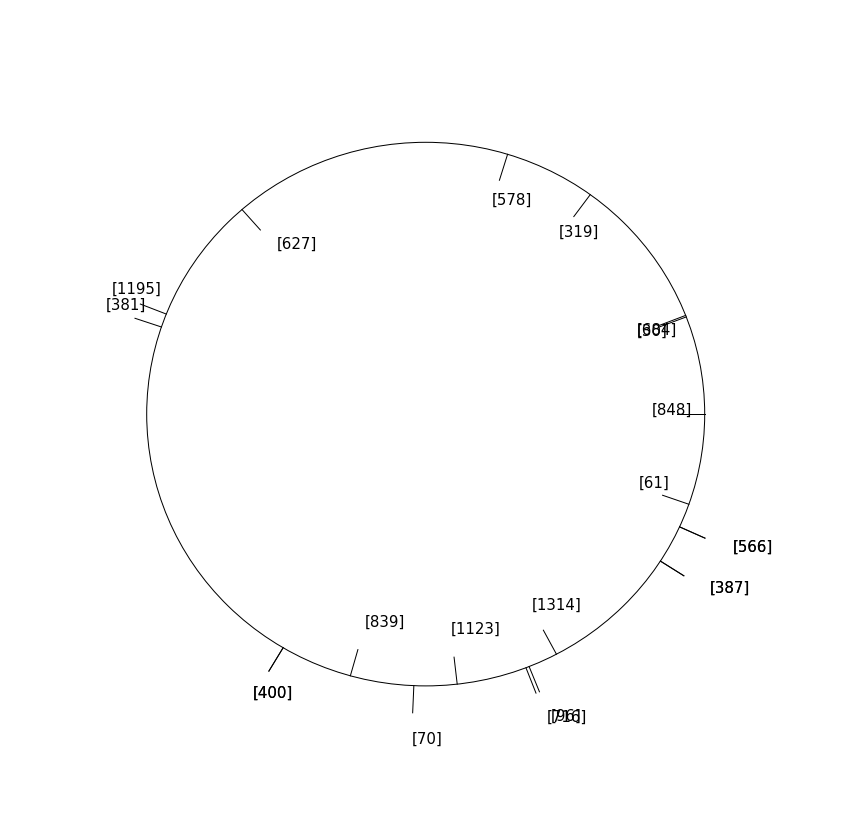

In [108]:
gamma = (1, 10, 2, 3)
visualizeShears(gamma, pantsDict, pantsInd)

In [109]:
print([(len(a), len(b), m,n,q,w) for (a,b,m,n,q,w) in getInequalityIndices2(posGeoList, pantsList, pantsInd, pantsDict, gamma)])

0.16854516204388456 0.36854516204388454 [381] [566]
0.16854516204388456 0.3729709331697387 [381] [566]
0.16854516204388456 0.7903575801780688 [381] [566]
0.16854516204388456 1.0349291331251096 [381] [566]
0.16854516204388456 1.78166537226909 [381] [566]
0.17297093316973874 0.36854516204388454 [381] [566]
0.17297093316973874 0.3729709331697387 [381] [566]
0.17297093316973874 0.7903575801780688 [381] [566]
0.17297093316973874 1.0349291331251096 [381] [566]
0.17297093316973874 1.78166537226909 [381] [566]
0.5903575801780688 0.7903575801780688 [381] [566]
0.5903575801780688 1.0349291331251096 [381] [566]
0.5903575801780688 1.78166537226909 [381] [566]
0.8349291331251095 1.0349291331251096 [381] [566]
0.8349291331251095 1.78166537226909 [381] [566]
1.5816653722690899 1.78166537226909 [381] [566]
3.1604249867710004 3.3604249867710005 [70] [400]
3.1604249867710004 3.6443926905137274 [70] [70]
3.444392690513727 3.6443926905137274 [716] [70]
4.266650070110502 0.36854516204388454 [566] [566]
4.2